# __Bid data platforms final project - Data analysis__

## Imports

In [1]:
import findspark
findspark.init()

import random
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.pandas as ps
ps.set_option('compute.ops_on_diff_frames', True)

%matplotlib widget
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/18 13:30:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Utils

In [2]:
figure_count = 0

In [3]:
def index_to_strings(argument, team_name, stat_name, value):
    switcher = {
        0: f'Team with highest {stat_name} is {team_name} - {value}',
        1: f'Team with 2nd highest {stat_name} is {team_name} - {value}',
        2: f'Team with 3rd highest {stat_name} is {team_name} - {value}',
    }

    return switcher.get(argument, "nothing")

In [4]:
def index_to_strings_players(argument, player_name, stat_name, value):
    switcher = {
        0: f'Player with highest {stat_name} is {player_name} - {value}',
        1: f'Player with 2nd highest {stat_name} is {player_name} - {value}',
        2: f'Player with 3rd highest {stat_name} is {player_name} - {value}',
    }

    return switcher.get(argument, "nothing")

## Read data

In [5]:
spark = SparkSession.builder.appName('treatmeant').getOrCreate()

23/01/18 13:30:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# Use Spark to read the training csv file.
teams = spark.read.csv("Teams.csv", inferSchema=True, header=True)
teams = teams.to_pandas_on_spark()
players = spark.read.csv("Players.csv", inferSchema=True, header=True)
players = players.to_pandas_on_spark()
games = spark.read.csv("Games.csv", inferSchema=True, header=True)
games = games.to_pandas_on_spark()
team_rosters = spark.read.csv("TeamRosters.csv", inferSchema=True, header=True)
team_rosters = team_rosters.to_pandas_on_spark()
game_line_up = spark.read.csv("GameLineUp.csv", inferSchema=True, header=True)
game_line_up = game_line_up.to_pandas_on_spark()
game_team_score = spark.read.csv("GameTeamScore.csv", inferSchema=True, header=True)
game_team_score = game_team_score.to_pandas_on_spark()
game_player_score = spark.read.csv("GamePlayerScore.csv", inferSchema=True, header=True)
game_player_score = game_player_score.to_pandas_on_spark()

## Display data info

In [7]:
teams_dict = {row['ID']: row['City'] + " " + row['TeamName'] for index, row in teams.iterrows()}
teams.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   City      30 non-null     object
 1   ID        30 non-null     int32 
 2   TeamCode  30 non-null     object
 3   TeamName  30 non-null     object
dtypes: int32(1), object(3)

In [8]:
teams

,City,ID,TeamCode,TeamName
0,Charlotte,1610612766,CHA,Hornets
1,Boston,1610612738,BOS,Celtics
2,New York,1610612752,NYK,Knicks
3,Portland,1610612757,POR,Trail Blazers
4,Minnesota,1610612750,MIN,Timberwolves
5,Chicago,1610612741,CHI,Bulls
6,Washington,1610612764,WAS,Wizards
7,New Orleans,1610612740,NOP,Pelicans
8,Dallas,1610612742,DAL,Mavericks
9,San Antonio,1610612759,SAS,Spurs


In [9]:
players_dict = {row['ID']: row['FirstName'] + " " + row['LastName'] for index, row in players.iterrows()}
players.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 951 entries, 0 to 950
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Country        948 non-null    object        
 1   DateOfBirth    948 non-null    datetime64[ns]
 2   FirstName      951 non-null    object        
 3   Height         940 non-null    object        
 4   ID             951 non-null    int32         
 5   LastName       951 non-null    object        
 6   Position       940 non-null    object        
 7   Weight         940 non-null    int32         
 8   YearsInLeague  948 non-null    int32         
dtypes: datetime64[ns](1), int32(3), object(5)

In [10]:
games = games.loc[(games['HomeTeamID'].isin(teams_dict.keys())) & (games['VisitorTeamID'].isin(teams_dict.keys())), :]
games.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1295 non-null   datetime64[ns]
 1   HomeTeamID     1295 non-null   int32         
 2   ID             1295 non-null   int32         
 3   LiveStatus     1295 non-null   object        
 4   VisitorTeamID  1295 non-null   int32         
dtypes: datetime64[ns](1), int32(3), object(1)

In [11]:
team_rosters.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 951 entries, 0 to 950
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   PlayerID  951 non-null    int32
 1   TeamID    951 non-null    int32
dtypes: int32(2)

In [172]:
game_line_up = game_line_up.loc[game_line_up['GameID'].isin(games['ID'].to_numpy())]
game_line_up.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 24107 entries, 0 to 24288
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   GameID    24107 non-null  int32
 1   PlayerID  24107 non-null  int32
 2   TeamID    24107 non-null  int32
dtypes: int32(3)

In [13]:
game_team_score = game_team_score.loc[game_team_score['TeamID'].isin(teams_dict.keys()), :]
game_team_score.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1429 entries, 0 to 1433
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AST        1429 non-null   int32
 1   BLK        1429 non-null   int32
 2   DREB       1429 non-null   int32
 3   FGA        1429 non-null   int32
 4   FGM        1429 non-null   int32
 5   FGPER      1429 non-null   int32
 6   FTA        1429 non-null   int32
 7   FTM        1429 non-null   int32
 8   FTPER      1429 non-null   int32
 9   GameID     1429 non-null   int32
 10  OREB       1429 non-null   int32
 11  PTS        1429 non-null   int32
 12  STL        1429 non-null   int32
 13  TO         1429 non-null   int32
 14  TeamID     1429 non-null   int32
 15  ThreePA    1429 non-null   int32
 16  ThreePM    1429 non-null   int32
 17  ThreePPER  1429 non-null   int32
dtypes: int32(18)

In [14]:
game_player_score = game_player_score.loc[game_player_score['PlayerID'].isin(players_dict.keys()), :]
game_player_score.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 24206 entries, 0 to 24288
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AST        24206 non-null  int32
 1   BLK        24206 non-null  int32
 2   DREB       24206 non-null  int32
 3   FGA        24206 non-null  int32
 4   FGM        24206 non-null  int32
 5   FGPER      24206 non-null  int32
 6   FTA        24206 non-null  int32
 7   FTM        24206 non-null  int32
 8   FTPER      24206 non-null  int32
 9   GameID     24206 non-null  int32
 10  OREB       24206 non-null  int32
 11  PTS        24206 non-null  int32
 12  PlayerID   24206 non-null  int32
 13  STL        24206 non-null  int32
 14  TO         24206 non-null  int32
 15  ThreePA    24206 non-null  int32
 16  ThreePM    24206 non-null  int32
 17  ThreePPER  24206 non-null  int32
dtypes: int32(18)

## __Season level analysis__

### Per game Per group statistics - from each game 2 values are taken into acount, one for each group

__Histogram of number of games a group played in the current season (2022-2023) so far__

In [15]:
finished_games = games.loc[games['LiveStatus'] == 'Final', :]

In [16]:
home_games = finished_games['HomeTeamID'].value_counts()
visitor_games = finished_games['VisitorTeamID'].value_counts()
indexes = home_games.index
total_games = pyspark.pandas.Series({teamID: home_games[teamID] + visitor_games[teamID] for teamID in home_games.index.to_list()})

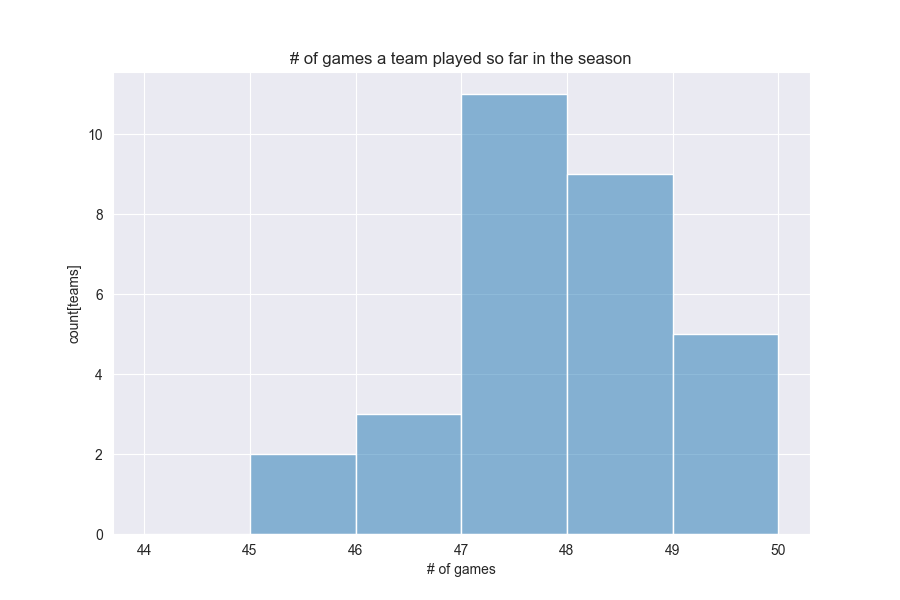

In [17]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(total_games.to_numpy(), alpha = 0.5, bins = np.arange(44, 51))
ax.set(title = "# of games a team played so far in the season", xlabel = '# of games', ylabel='count[teams]')
plt.legend([],[], frameon = False)
plt.show(fig);

__Histogram of number of players per game (for a single group) in the current season (2022-2023) so far__

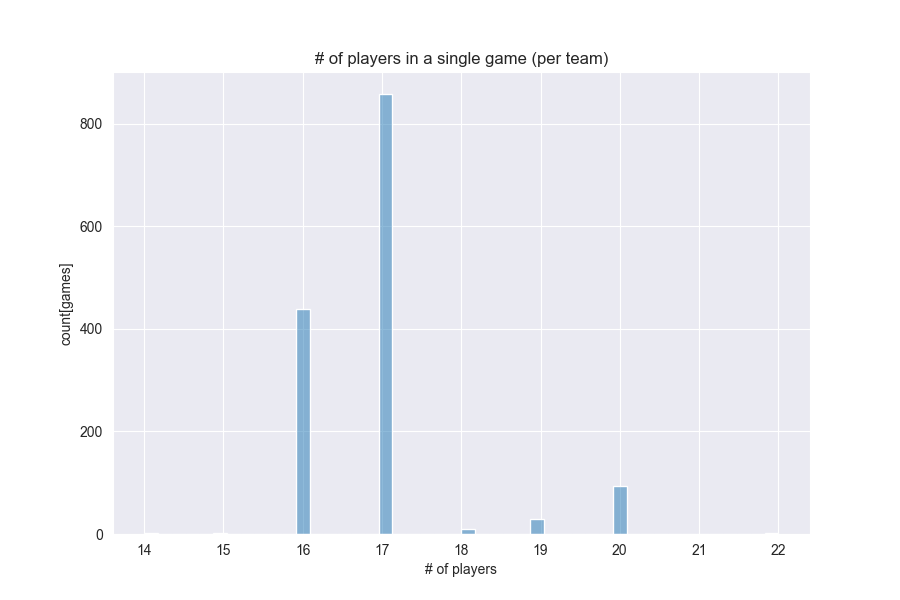

In [18]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_line_up.groupby(['GameID', 'TeamID']).count().to_numpy(), alpha = 0.5)
ax.set(title = "# of players in a single game (per team)", xlabel = '# of players', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Field goals

__Histogram of field goals made out of field goals attempted in a single game per group in the current season (2022-2023) so far__

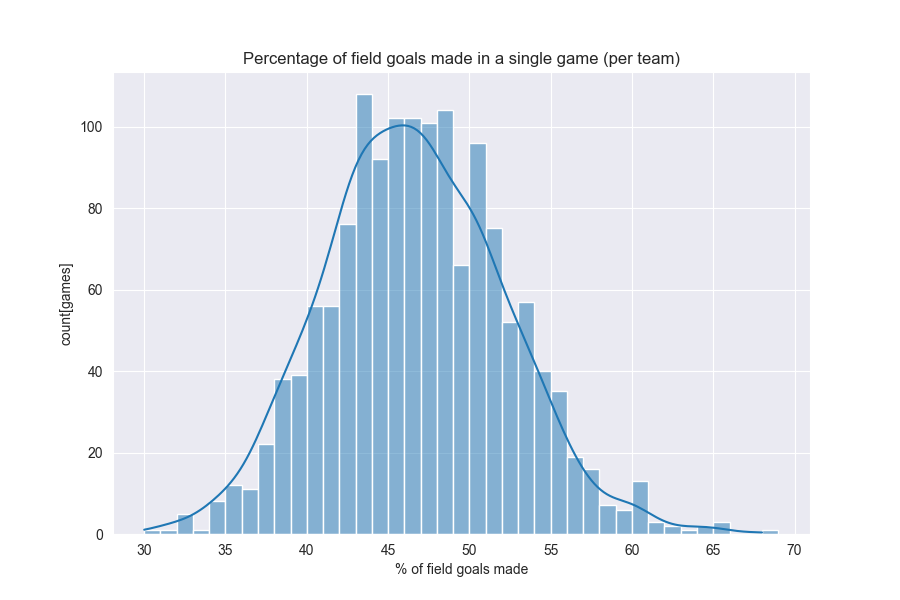

In [19]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['FGPER'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(30, 70))
ax.set(title = "Percentage of field goals made in a single game (per team)", xlabel = '% of field goals made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [20]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'FGPER']].groupby(['TeamID']).mean().nlargest(3, columns='FGPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'FG%',  f'{team.values[0]:.2f}%'))


Team with highest FG% is Denver Nuggets - 50.17%
Team with 2nd highest FG% is Brooklyn Nets - 50.13%
Team with 3rd highest FG% is Minnesota Timberwolves - 48.82%


### Three points field goals

__Histogram of three point field goal made out of attempted in a single game per group in the current season (2022-2023) so far__

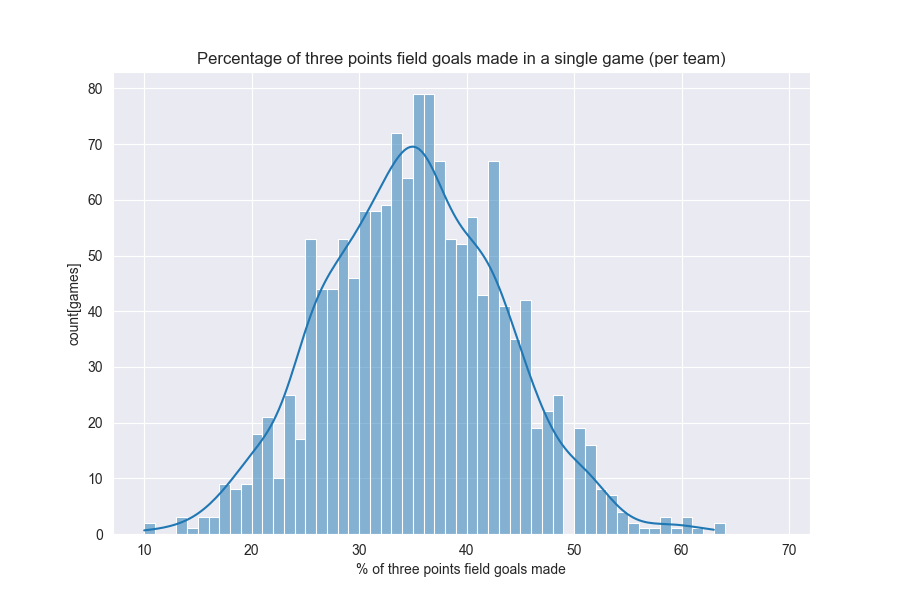

In [21]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['ThreePPER'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(10, 70))
ax.set(title = "Percentage of three points field goals made in a single game (per team)", xlabel = '% of three points field goals made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [22]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'ThreePPER']].groupby(['TeamID']).mean().nlargest(3, columns='ThreePPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], '3FG%',  f'{team.values[0]:.2f}%'))


Team with highest 3FG% is Denver Nuggets - 38.83%
Team with 2nd highest 3FG% is Brooklyn Nets - 37.93%
Team with 3rd highest 3FG% is Phoenix Suns - 37.27%


In [23]:
game_player_score.shape

(24206, 18)

In [24]:
grouped = game_player_score.to_pandas().loc[:, ['PlayerID', 'ThreePA', 'ThreePPER']].groupby('PlayerID')
grouped.filter(lambda x: x['ThreePA'].count() > 10).loc[:, ['PlayerID', 'ThreePPER']].groupby('PlayerID').mean()

,ThreePPER
PlayerID,
2544,19.583333
2617,0.000000
2738,1.063830
101108,20.229167
200752,14.200000
...,...
1631298,4.255319
1631306,5.958333
1631309,3.260870


In [25]:
grouped = game_player_score.to_pandas().loc[:, ['PlayerID', 'ThreePA', 'ThreePPER']].groupby('PlayerID')
three_best_players = grouped.filter(lambda x: x['ThreePA'].count() > 10).loc[:, ['PlayerID', 'ThreePPER']].groupby('PlayerID').mean().nlargest(3, columns='ThreePPER')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], '3FG%', f'{player.values[0]:.2f}%'))

Player with highest 3FG% is Damion Lee - 43.71%
Player with 2nd highest 3FG% is Buddy Hield - 42.50%
Player with 3rd highest 3FG% is Kentavious Caldwell-Pope - 41.81%


__Histogram of three point field goal made out of field goal made in a single game per group in the current season (2022-2023) so far__

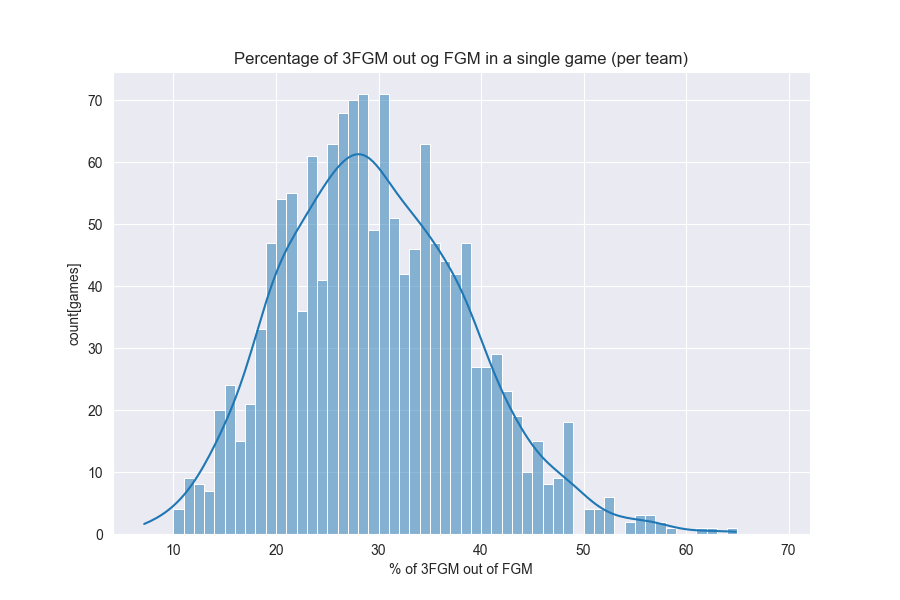

In [26]:
game_team_score['3FGM_to_FGM'] = game_team_score['ThreePM'] * 100 /game_team_score['FGM']
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['3FGM_to_FGM'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(10, 70))
ax.set(title = "Percentage of 3FGM out og FGM in a single game (per team)", xlabel = '% of 3FGM out of FGM', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [27]:
three_best_teams = game_team_score.loc[:, ['TeamID', '3FGM_to_FGM']].groupby(['TeamID']).mean().nlargest(3, columns='3FGM_to_FGM')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'precentage of 3FGM out of FGM', f'{team.values[0]:.2f}%'))

Team with highest precentage of 3FGM out of FGM is Dallas Mavericks - 38.40%
Team with 2nd highest precentage of 3FGM out of FGM is Golden State Warriors - 37.48%
Team with 3rd highest precentage of 3FGM out of FGM is Boston Celtics - 37.26%


### Free throws

__Histogram of free throws made out of free throws attempted in a single game per group in the current season (2022-2023) so far__

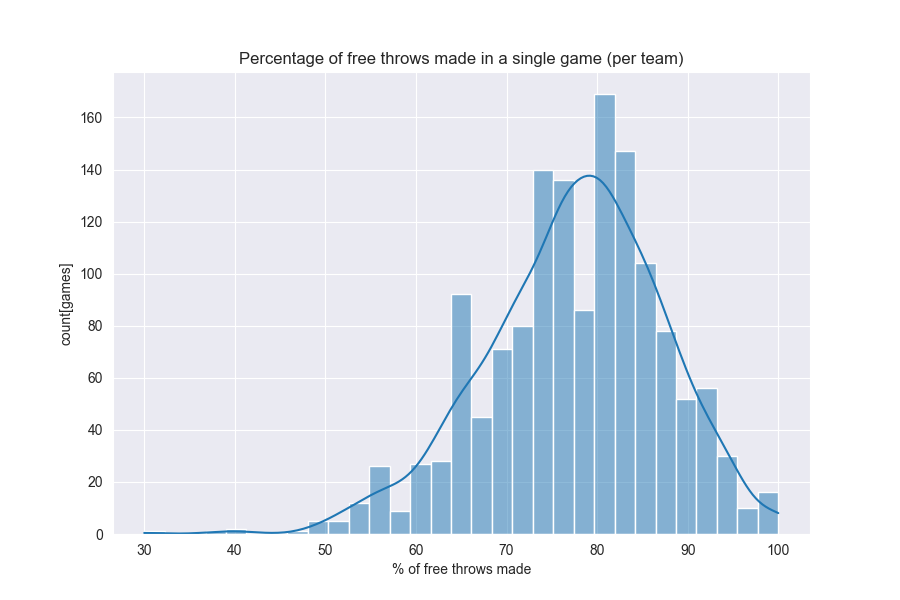

In [28]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['FTPER'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "Percentage of free throws made in a single game (per team)", xlabel = '% of free throws made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [29]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'FTPER']].groupby(['TeamID']).mean().nlargest(3, columns='FTPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'FT%', f'{team.values[0]:.2f}%'))

Team with highest FT% is Boston Celtics - 82.94%
Team with 2nd highest FT% is Philadelphia 76ers - 82.33%
Team with 3rd highest FT% is Miami Heat - 82.14%


### Rebounds

__Histogram of total rebounds in a single game per group in the current season (2022-2023) so far__

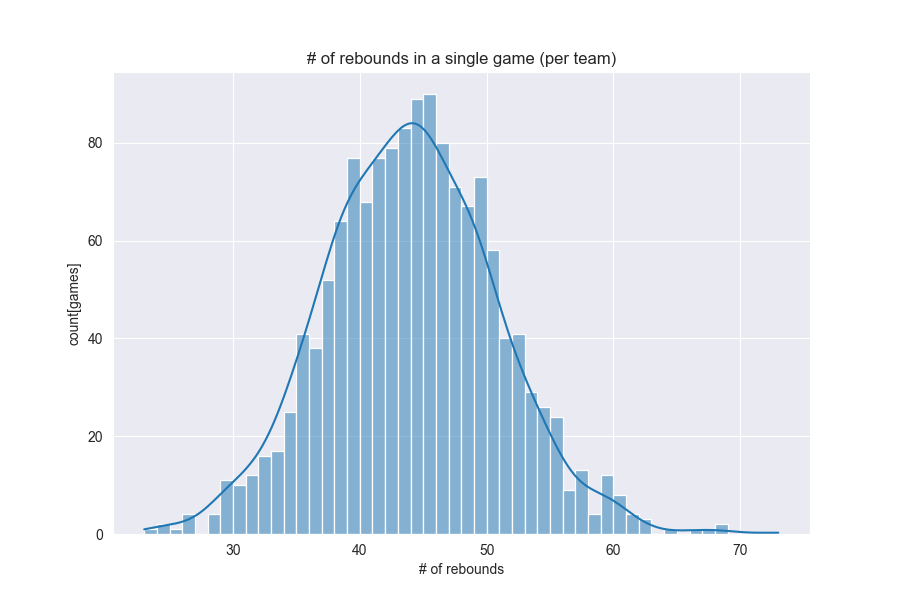

In [30]:
game_team_score['REB'] = game_team_score['OREB'] + game_team_score['DREB']
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['REB'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(23, 70))
ax.set(title = "# of rebounds in a single game (per team)", xlabel = '# of rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [31]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'REB']].groupby(['TeamID']).mean().nlargest(3, columns='REB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of rebounds is Memphis Grizzlies - 48.87
Team with 2nd highest avg number of rebounds is Milwaukee Bucks - 48.38
Team with 3rd highest avg number of rebounds is New York Knicks - 47.64


In [32]:
game_player_score['REB'] = game_player_score['OREB'] + game_player_score['DREB']
three_best_players = game_player_score.loc[:, ['PlayerID', 'REB']].groupby(['PlayerID']).mean().nlargest(3, columns='REB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of rebounds is Domantas Sabonis - 11.84
Player with 2nd highest avg number of rebounds is Nikola Vucevic - 10.77
Player with 3rd highest avg number of rebounds is Julius Randle - 10.11


__Histogram of offensive rebounds in a single game per group in the current season (2022-2023) so far__

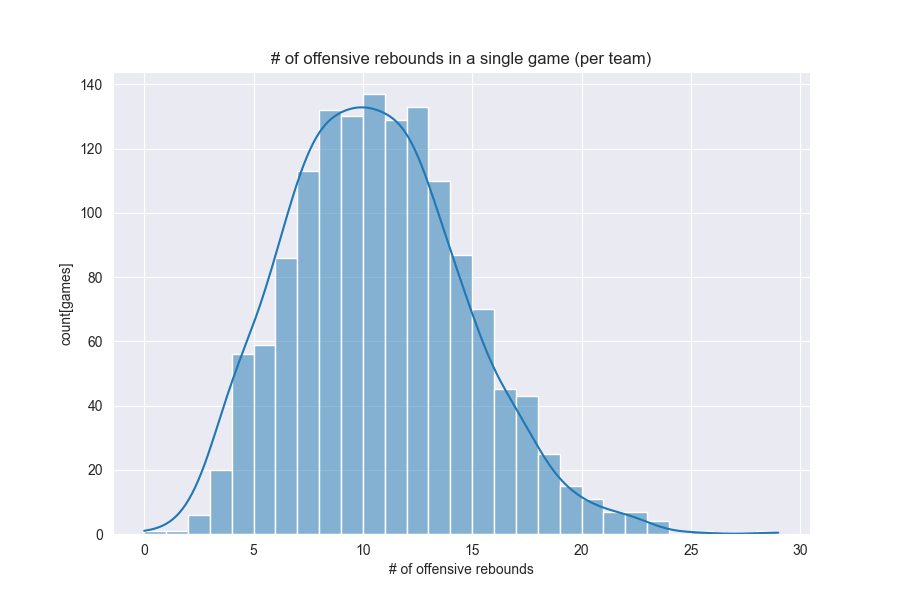

In [33]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['OREB'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(0, 30))
ax.set(title = "# of offensive rebounds in a single game (per team)", xlabel = '# of offensive rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [34]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'OREB']].groupby(['TeamID']).mean().nlargest(3, columns='OREB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of offensive rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of offensive rebounds is Houston Rockets - 13.15
Team with 2nd highest avg number of offensive rebounds is New York Knicks - 13.02
Team with 3rd highest avg number of offensive rebounds is Memphis Grizzlies - 13.00


In [35]:
three_best_players = game_player_score.loc[:, ['PlayerID', 'OREB']].groupby(['PlayerID']).mean().nlargest(3, columns='OREB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of offensive rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of offensive rebounds is Steven Adams - 4.34
Player with 2nd highest avg number of offensive rebounds is Mitchell Robinson - 3.66
Player with 3rd highest avg number of offensive rebounds is Mason Plumlee - 3.16


__Histogram of defensive rebounds in a single game per group in the current season (2022-2023) so far__

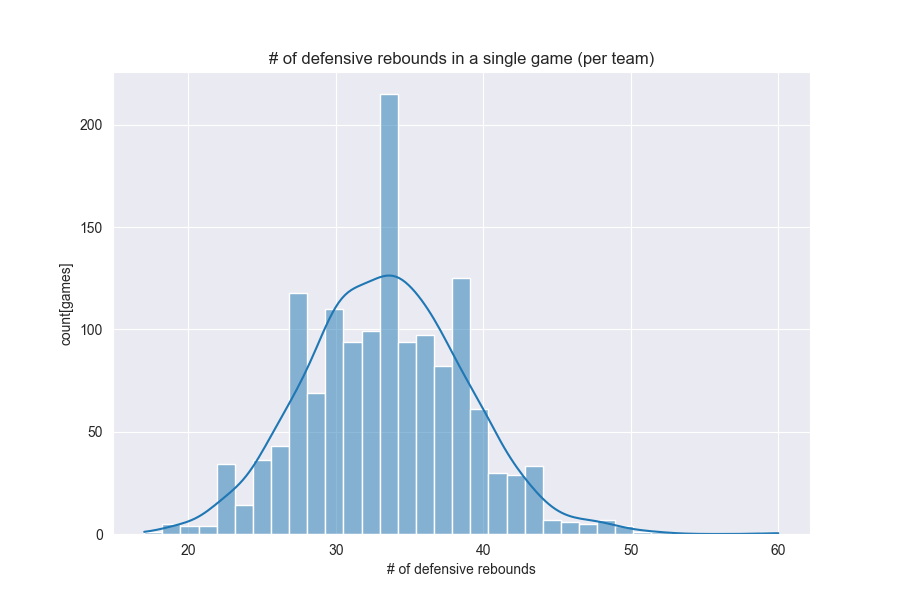

In [36]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['DREB'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "# of defensive rebounds in a single game (per team)", xlabel = '# of defensive rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [37]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'DREB']].groupby(['TeamID']).mean().nlargest(3, columns='DREB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of defensive rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of defensive rebounds is Milwaukee Bucks - 36.25
Team with 2nd highest avg number of defensive rebounds is Los Angeles Lakers - 36.08
Team with 3rd highest avg number of defensive rebounds is Memphis Grizzlies - 35.87


In [38]:
three_best_players = game_player_score.loc[:, ['PlayerID', 'DREB']].groupby(['PlayerID']).mean().nlargest(3, columns='DREB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of defensive rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of defensive rebounds is Domantas Sabonis - 9.00
Player with 2nd highest avg number of defensive rebounds is Nikola Vucevic - 8.72
Player with 3rd highest avg number of defensive rebounds is Julius Randle - 8.13


### Asists

__Histogram of assits in a single game per group in the current season (2022-2023) so far__

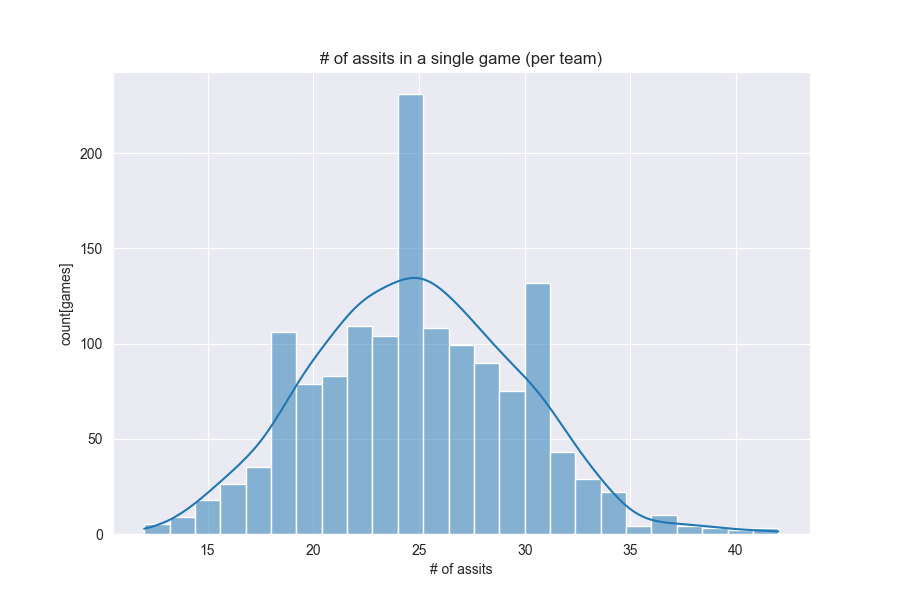

In [39]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['AST'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "# of assits in a single game (per team)", xlabel = '# of assits', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [40]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'AST']].groupby(['TeamID']).mean().nlargest(3, columns='AST')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg of assits', f'{team.values[0]:.2f}'))

Team with highest avg of assits is Golden State Warriors - 28.98
Team with 2nd highest avg of assits is Denver Nuggets - 28.23
Team with 3rd highest avg of assits is Sacramento Kings - 27.24


### Blocks

__Histogram of blocks in a single game per group in the current season (2022-2023) so far__

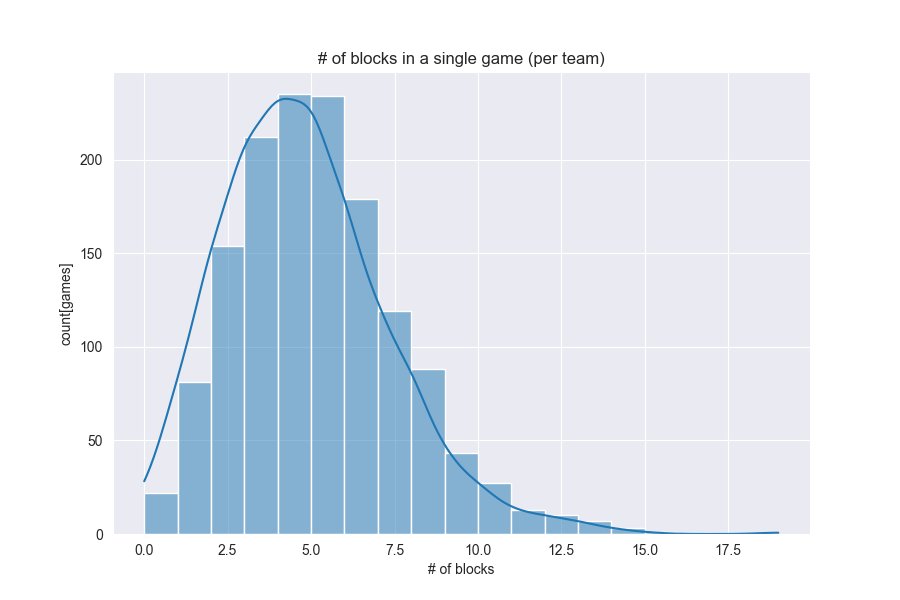

In [41]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['BLK'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(0, 18))
ax.set(title = "# of blocks in a single game (per team)", xlabel = '# of blocks', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [42]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'BLK']].groupby(['TeamID']).mean().nlargest(3, columns='BLK')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg of blocks', f'{team.values[0]:.2f}'))

Team with highest avg of blocks is Brooklyn Nets - 6.91
Team with 2nd highest avg of blocks is Indiana Pacers - 6.15
Team with 3rd highest avg of blocks is Memphis Grizzlies - 5.98


### Steals

__Histogram of steals in a single game per group in the current season (2022-2023) so far__

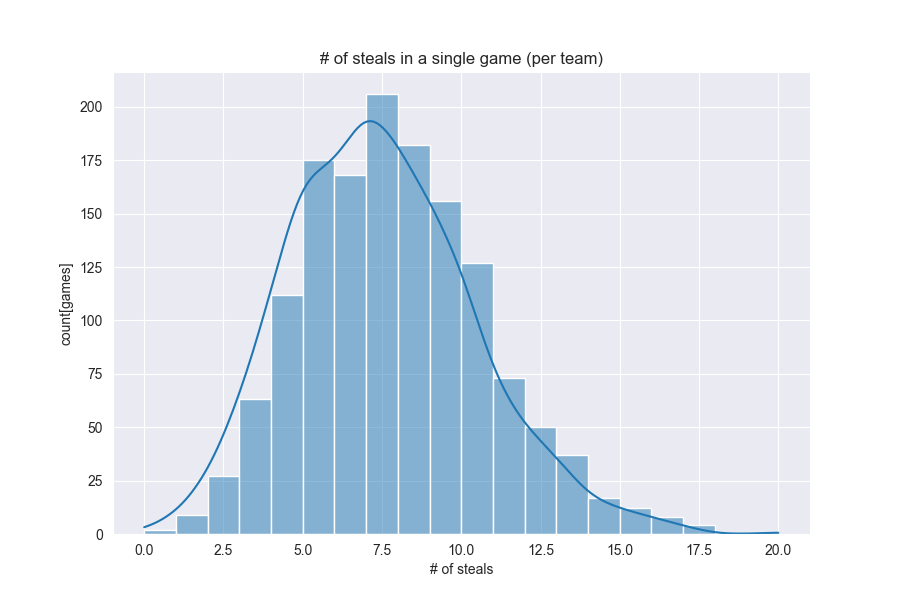

In [43]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['STL'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "# of steals in a single game (per team)", xlabel = '# of steals', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Turnovers

__Histogram of turnovers in a single game per group in the current season (2022-2023) so far__

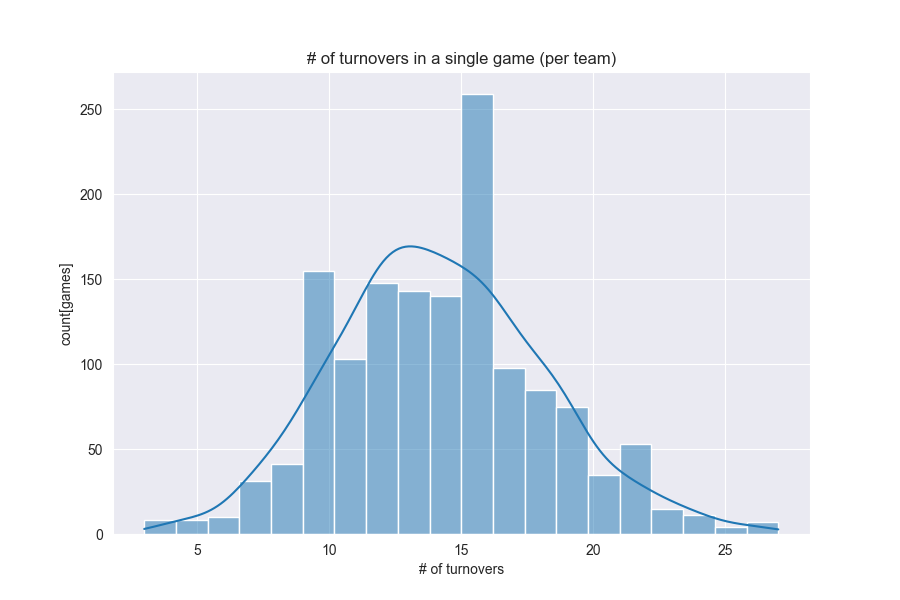

In [44]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['TO'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "# of turnovers in a single game (per team)", xlabel = '# of turnovers', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Teams "Power Ranking"

In [45]:
game_team_score_grouped = game_team_score.groupby(['TeamID']).mean().reset_index()

In [46]:
teams_wins = {teamID: 0 for teamID in teams_dict.keys()}    

for i, row in finished_games.iterrows():        
    visitor_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'PTS'].to_numpy()[0]
    home_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'PTS'].to_numpy()[0]
    
    if visitor_team_pts > home_team_pts:
       teams_wins[row['VisitorTeamID']] += 1

    else:
        teams_wins[row['HomeTeamID']] += 1

for key, value in teams_wins.items():
    game_team_score_grouped.loc[game_team_score_grouped['TeamID'] == key, 'wins'] = value

In [47]:
game_team_score_grouped['TeamScore'] = 0.2 * game_team_score_grouped['wins'] + \
                                        0.2 * game_team_score_grouped['PTS'] + \
                                        0.2 * game_team_score_grouped['AST'] + \
                                        0.1 * game_team_score_grouped['STL'] + \
                                        0.1 * game_team_score_grouped['BLK'] + \
                                        0.2 * game_team_score_grouped['REB']

In [48]:
three_best_teams = game_team_score_grouped.nlargest(3, columns='TeamScore')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[team['TeamID']], 'overall score', ''))

23/01/18 13:31:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Team with highest overall score is Boston Celtics - 
Team with 2nd highest overall score is Memphis Grizzlies - 
Team with 3rd highest overall score is Denver Nuggets - 


### Players "Power Ranking"

In [49]:
game_player_score_grouped = game_player_score.groupby(['PlayerID']).mean()
game_player_score_grouped['PlayerScore'] = 0.4 * game_player_score_grouped['PTS'] + \
                                            0.2 * game_player_score_grouped['AST'] + \
                                            0.1 * game_player_score_grouped['STL'] + \
                                            0.1 * game_player_score_grouped['BLK'] + \
                                            0.2 * game_player_score_grouped['REB']

In [50]:
three_best_players = game_player_score_grouped.nlargest(3, columns='PlayerScore')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'overall score', ''))

Player with highest overall score is Luka Doncic - 
Player with 2nd highest overall score is Jayson Tatum - 
Player with 3rd highest overall score is Kevin Durant - 


## Team level analysis
seleceted team - Phoenix Suns

In [173]:
selected_team_ID = 1610612756
selected_team_games = finished_games.loc[(finished_games['HomeTeamID'] == selected_team_ID) | (finished_games['VisitorTeamID'] == selected_team_ID), :]

for i, row in selected_team_games.iterrows():
    # print(type(row['HomeTeamID']))
    if row['HomeTeamID'] == selected_team_ID:
        home = True
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'home'] = True
    else:
        home = False
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'home'] = False

    selected_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'PTS'].to_numpy()[0]

    # Fill the df with stats from the game
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'PTS'] = selected_team_pts
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FGPER'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FGPER'].to_numpy()[0]
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'ThreePPER'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'ThreePPER'].to_numpy()[0]
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], '3FGM_to_FGM'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), '3FGM_to_FGM'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'AST'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'AST'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'BLK'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'BLK'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'DREB'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'DREB'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FGA'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FGA'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FGM'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FGM'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FTA'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FTA'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FTM'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FTM'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FTPER'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FTPER'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'ThreePA'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'ThreePA'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'ThreePM'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'ThreePM'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'OREB'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'OREB'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'REB'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'REB'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'STL'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'STL'].to_numpy()[0]
    # selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'TO'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'TO'].to_numpy()[0]

    # print(selected_team_pts)

    if home:
        other_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'PTS'].to_numpy()[0]
    else:
        other_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'PTS'].to_numpy()[0]
    
    # print(other_team_pts)

    if other_team_pts > selected_team_pts:
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'result'] = 'L'
    else:
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'result'] = 'W'


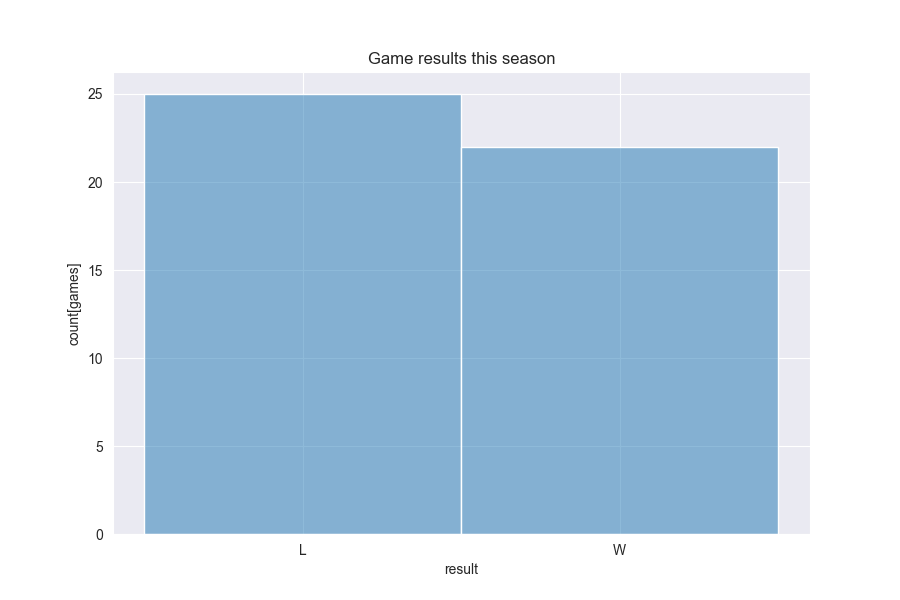

In [174]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_team_games['result'].to_numpy(), alpha = 0.5)
ax.set(title = "Game results this season", xlabel = 'result', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

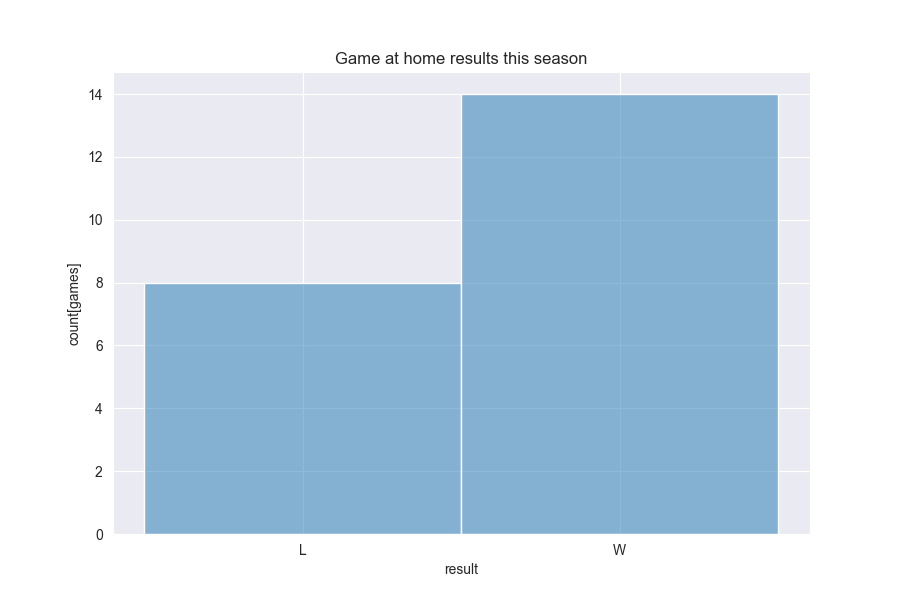

In [175]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_team_games.loc[selected_team_games['home'] == True, 'result'].to_numpy(), alpha = 0.5)
ax.set(title = "Game at home results this season", xlabel = 'result', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

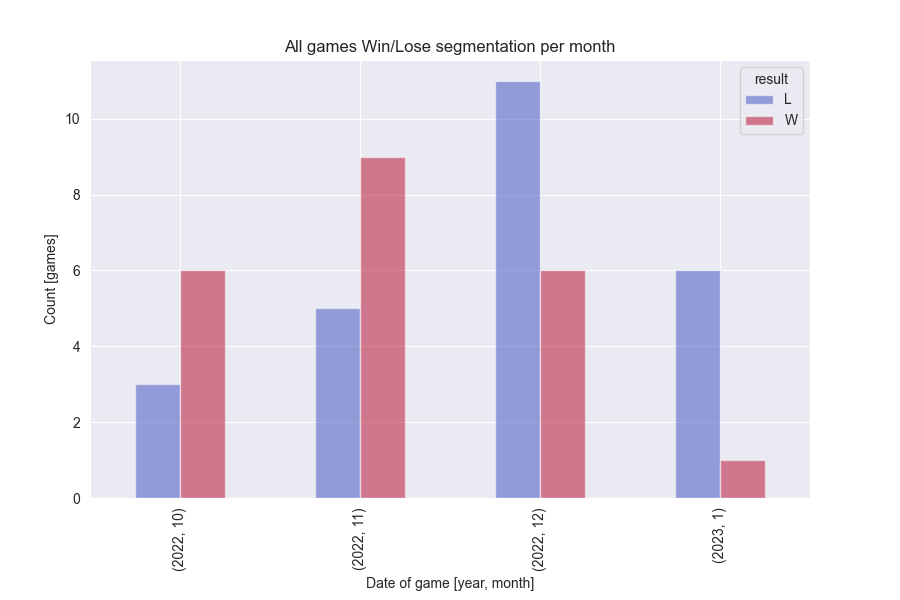

In [176]:
selected_team_games_copy = selected_team_games.to_pandas().set_index('Date')

line_plot = selected_team_games_copy.home

line_plot2 = selected_team_games_copy.result

bar_plot = line_plot.groupby([line_plot.index.year, line_plot.index.month, line_plot2]).count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('All games Win/Lose segmentation per month')
plt.show(fig);

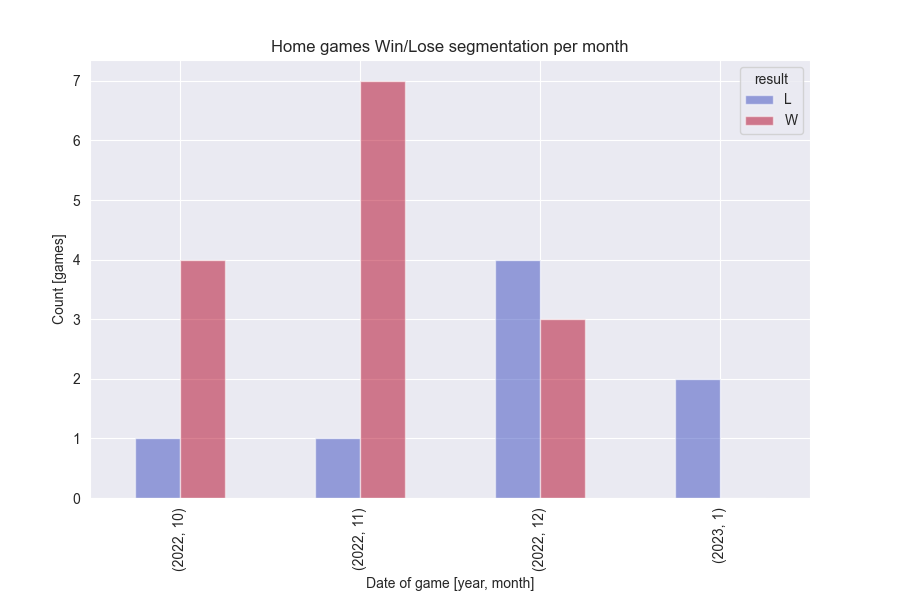

In [177]:
selected_team_games_at_home_copy = selected_team_games.loc[selected_team_games['home'] == True, :].to_pandas().set_index('Date')

line_plot = selected_team_games_at_home_copy.home

line_plot2 = selected_team_games_at_home_copy.result

bar_plot = line_plot.groupby([line_plot.index.year, line_plot.index.month, line_plot2]).count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('Home games Win/Lose segmentation per month')
plt.show(fig);

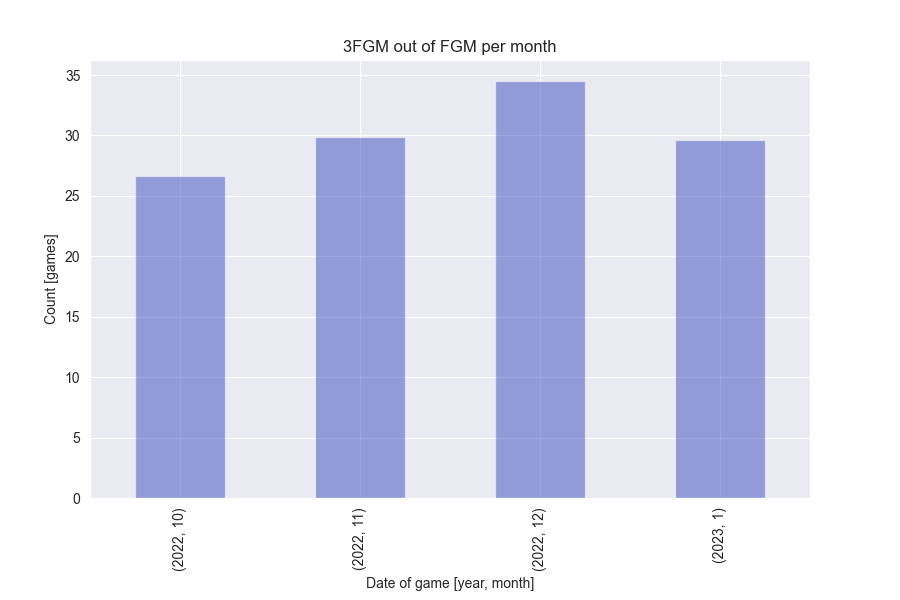

23/01/19 17:59:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1077082 ms exceeds timeout 120000 ms
23/01/19 17:59:19 WARN SparkContext: Killing executors is not supported by current scheduler.


In [178]:
line_plot = selected_team_games_copy.home

bar_plot = selected_team_games_copy['3FGM_to_FGM'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('3FGM out of FGM per month')
plt.show(fig);

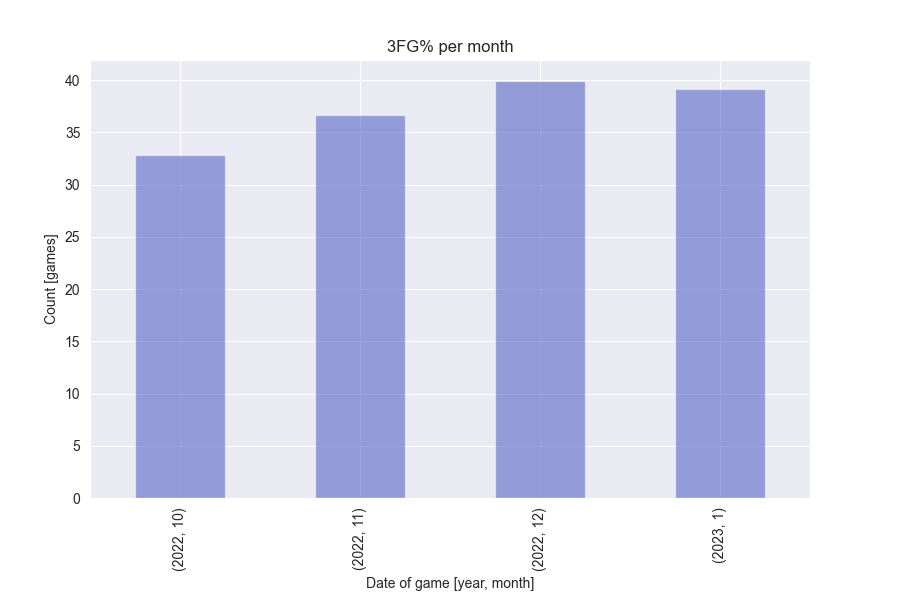

In [179]:
bar_plot = selected_team_games_copy['ThreePPER'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('3FG% per month')
plt.show(fig);

In [242]:

grouped = pd.DataFrame(game_line_up.loc[game_line_up['TeamID'] == selected_team_ID, ['GameID', 'PlayerID']].to_pandas().groupby('GameID')['PlayerID'].apply(list))
for gameID in grouped.index:
    grouped.loc[gameID, 'result'] = selected_team_games.loc[selected_team_games['ID'] == gameID, 'result'].to_numpy()[0]

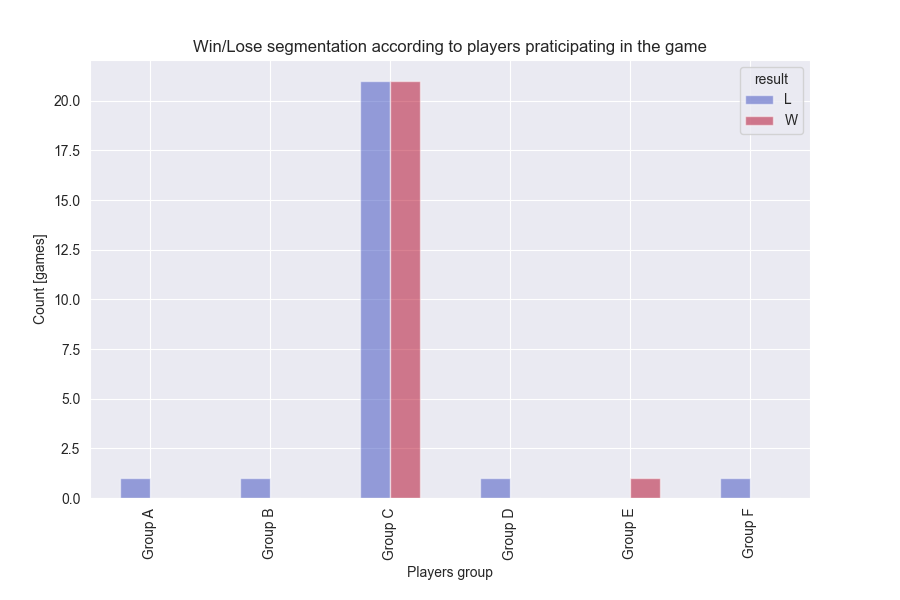

In [248]:
grouped['PlayerID'] = grouped.PlayerID.apply(tuple)
bar_plot = grouped.reset_index().groupby(['PlayerID', 'result'])['GameID'].count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Players group')
ax.set_ylabel('Count [games]')
ax.set_title('Win/Lose segmentation according to players praticipating in the game')
ax.set_xticklabels(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F'])
plt.show(fig);

In [253]:
switcher = {
        0: 'A',
        1: 'B',
        2: 'C',
        3: 'D',
        4: 'E',
        5: 'F'
    }
for i, players in enumerate(bar_plot.index):
    print(f'Players in group {switcher[i]}:')
    print([players_dict[player] for player in players])

Players in group A:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Duane Washington Jr.', 'Timothe Luwawu-Cabarrot', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre Ayton', 'Cameron Johnson', 'Mikal Bridges', 'Frank Jackson', 'Jae Crowder']
Players in group B:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Duane Washington Jr.', 'Timothe Luwawu-Cabarrot', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Adonis Arms', 'Deandre Ayton', 'Cameron Johnson', 'Mikal Bridges', 'Saben Lee', 'Jae Crowder']
Players in group C:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Duane Washington Jr.', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre Ayton', 'Cameron Johnson', 'Mikal Bridges', 'Jae Crowder']
Players in group D:
['Torrey Craig